<a href="https://colab.research.google.com/github/Sauptik23/DataMap/blob/main/Innovative_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Downloads

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 39.23 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.


In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-11-25 05:27:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-11-25 05:27:10 (77.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



#Imports

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from helper_functions import calculate_results
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import TextVectorization
import os

#Preprocessing

In [4]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [37]:

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

##get_lines()

In [6]:
def get_lines(filename):
  with open(filename,"r") as f:
    return f.readlines()


In [7]:
train_lines=get_lines(data_dir + "train.txt")

##Preprocess_text_with_line_numbers

In [8]:
def preprocess_text_with_line_numbers(filename):
  input_lines=get_lines(filename)
  abstract_lines=""
  abstract_samples=[]

  for line in input_lines:
    if line.startswith("###"):
      abstract_id=line
      abstract_lines=""
    elif line.isspace():
      abstract_line_split=abstract_lines.splitlines()
      for abstract_line_number,abstract_line in enumerate(abstract_line_split):
        line_data={}
        target_text_split=abstract_line.split("\t")
        line_data["target"]=target_text_split[0]
        line_data["text"]=target_text_split[1].lower()
        line_data["line_number"]=abstract_line_number
        line_data["total_lines"]=len(abstract_line_split)
        abstract_samples.append(line_data)
    else:
      abstract_lines+=line
  return abstract_samples


In [9]:
train_samples=preprocess_text_with_line_numbers(data_dir+"train.txt")
test_samples=preprocess_text_with_line_numbers(data_dir+"test.txt")
val_samples=preprocess_text_with_line_numbers(data_dir+"dev.txt")

In [10]:
train_df=pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df=pd.DataFrame(test_samples)


In [11]:
train_sentences=train_df["text"].tolist()
val_sentences=val_df["text"].tolist()
test_sentences=test_df["text"].tolist()

##OneHot Encoding

In [12]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

##Label Encoding

In [13]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())


In [14]:
num_classes=len(label_encoder.classes_)
class_names=label_encoder.classes_

#Model 0 (TF-IDF Baseline using MultinomialNB)

In [15]:
model_0=Pipeline([
    ("tf-idf ",TfidfVectorizer()),
    ("clf",MultinomialNB())
])

model_0.fit(X=train_sentences,
            y=train_labels_encoded);

In [16]:
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [17]:
baseline_preds = model_0.predict(val_sentences)

In [18]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)

In [19]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)

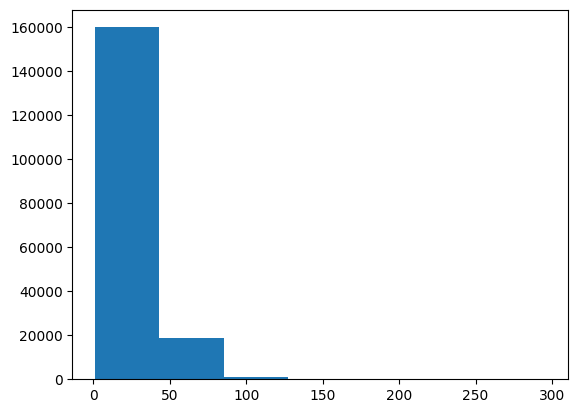

In [20]:
plt.hist(sent_lens, bins=7);

In [21]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

#Create Text Vectorizer

In [22]:
max_tokens = 68000

In [23]:
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=55)

In [24]:
text_vectorizer.adapt(train_sentences)

##Testing the Text Vectorizer

In [25]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
this approach has the potential to enhance the clinical value of the overall nihss score .

Length of text: 16

Vectorized text:
[[  23  453  139    2  343    6 1335    2   47  529    4    2  188 5894
   101    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [26]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [27]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

##Embedding

In [28]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
this approach has the potential to enhance the clinical value of the overall nihss score .

Sentence after vectorization (before embedding):
[[  23  453  139    2  343    6 1335    2   47  529    4    2  188 5894
   101    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[ 0.00476041 -0.04834119 -0.03985045 ... -0.04072862 -0.02147197
   -0.01575103]
  [ 0.04588139 -0.04500521  0.03723234 ... -0.0244108  -0.04604955
   -0.01651411]
  [-0.00952115  0.04649821 -0.02613246 ... -0.03418557 -0.0046416
    0.03435728]
  ...
  [-0.02168169 -0.02972137 -0.00628183 ...  0.03718458 -0.03241377
   -0.0387912 ]
  [-0.02168169 -0.02972137 -0.00628183 ...  0.03718458 -0.03241377
   -0.0387912 ]
  [-0.02168169 -0.02972137 -0.00628183 ...  0.03718458 -0.03241377
   -0.0387912 ]]]

Embedded s

In [29]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))


In [30]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#Model - 1

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)


model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [ ]:
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 31s 35ms/step - loss: 0.9054 - accuracy: 0.6436 - val_loss: 0.6775 - val_accuracy: 0.7414
Epoch 2/3
562/562 [==============================] - 6s 10ms/step - loss: 0.6508 - accuracy: 0.7597 - val_loss: 0.6236 - val_accuracy: 0.7736
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.6118 - accuracy: 0.7771 - val_loss: 0.5925 - val_accuracy: 0.7869


#Model-2

In [31]:
def split_chars(text):
  return " ".join(list(text))


In [32]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [33]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)

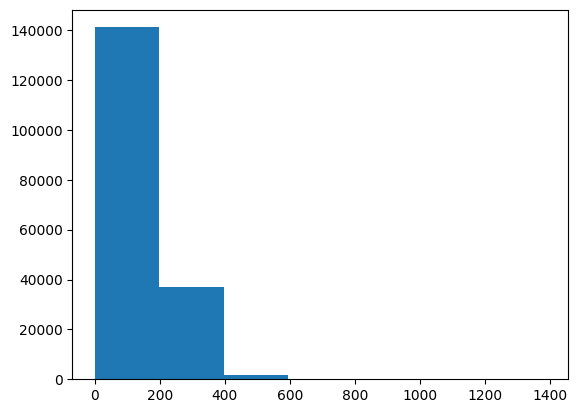

In [34]:
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [35]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [38]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [39]:
NUM_CHAR_TOKENS = len(alphabet) + 2

##Character Vectorizer


In [40]:
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

In [41]:
char_vectorizer.adapt(train_chars)

##Character Embedding

In [42]:
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25,
                              mask_zero=False,
                              name="char_embed")

##Conv1D Model on CHaracter Embeddings

In [43]:
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [44]:
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d (Conv1D)             (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 5

In [45]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [46]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 13s 6ms/step - loss: 1.2750 - accuracy: 0.4839 - val_loss: 1.0432 - val_accuracy: 0.5951
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 1.0014 - accuracy: 0.5978 - val_loss: 0.9327 - val_accuracy: 0.6307
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9188 - accuracy: 0.6407 - val_loss: 0.8592 - val_accuracy: 0.6729


In [47]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 7s 7ms/step - loss: 0.8779 - accuracy: 0.6616


[0.8779230713844299, 0.6616244912147522]

In [49]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.18144365, 0.45477003, 0.05299162, 0.28771752, 0.02307709],
       [0.3907318 , 0.47005332, 0.01247702, 0.10000787, 0.02673005],
       [0.23198026, 0.22951554, 0.16184609, 0.3300689 , 0.04658924],
       ...,
       [0.00640915, 0.01621056, 0.02653512, 0.00230517, 0.94854003],
       [0.02836484, 0.0591562 , 0.5730153 , 0.02704549, 0.31241822],
       [0.2770458 , 0.5029553 , 0.10813028, 0.07609344, 0.03577511]],
      dtype=float32)

In [50]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 2, 1])>

In [51]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 66.1624520058255,
 'precision': 0.6573369832991327,
 'recall': 0.661624520058255,
 'f1': 0.648054138668622}

#Model 3 (Hybrid Embeddings)

In [52]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [53]:
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

In [54]:
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

In [55]:
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

In [57]:
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

In [58]:
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [59]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

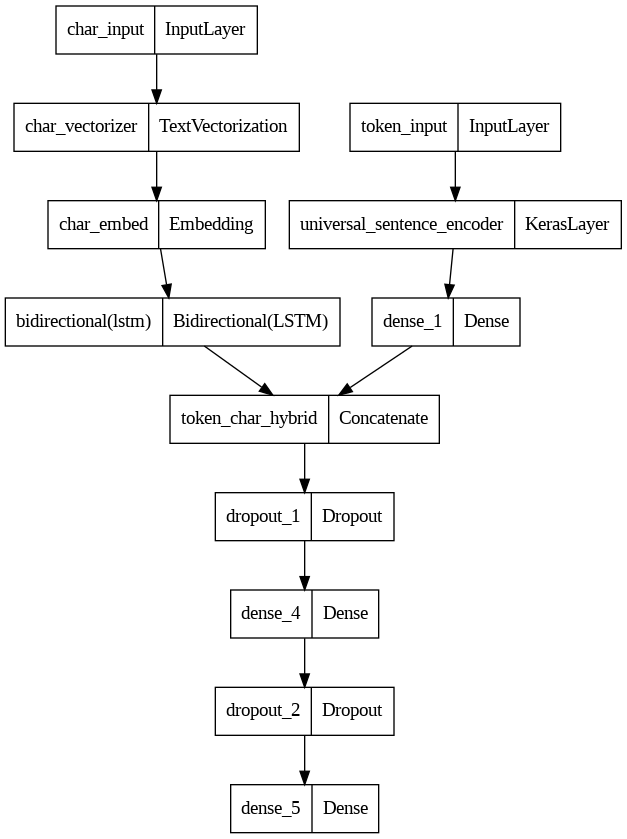

In [60]:
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [61]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [62]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [63]:
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [64]:
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 34s 37ms/step - loss: 0.9697 - accuracy: 0.6147 - val_loss: 0.7747 - val_accuracy: 0.7021
Epoch 2/3
562/562 [==============================] - 18s 31ms/step - loss: 0.7911 - accuracy: 0.6966 - val_loss: 0.7106 - val_accuracy: 0.7340
Epoch 3/3
562/562 [==============================] - 18s 31ms/step - loss: 0.7623 - accuracy: 0.7074 - val_loss: 0.6945 - val_accuracy: 0.7420
